In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

In [5]:
from scipy import stats
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

!pip install openpyxl


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


# Data import and cleaning

- Import data
- Understand general structure
- Manage nulls, duplicated, outliers, anomalies

In [6]:
data =  pd.read_excel('data/online_retail.xlsx', index_col=0)  

In [11]:
df = data.copy()

In [15]:
df.reset_index(inplace = True)

In [16]:
df_s = df.sample(20000, random_state=66)
df_s["InvoiceDate"] = df_s["InvoiceDate"].dt.date
df_s["OrderValue"] = df_s["Quantity"] * df_s["UnitPrice"]
snapshot_date = max(df_s['InvoiceDate']) + datetime.timedelta(days=1)
customers = df_s.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                            'InvoiceNo': 'count','OrderValue': 'sum'})
customers.rename(columns = {'InvoiceDate': 'Recency','InvoiceNo': 'Frequency',
                            'OrderValue': 'MonetaryValue'}, inplace=True)

In [20]:
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
3113,5.088822,0.621104,2.841805
3114,11.445753,0.000000,-2.336164
3115,2.624417,0.000000,2.943383
3116,1.615992,2.105863,4.406636
3117,6.537395,0.621104,3.264824


In [21]:
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[ 0.  0. -0.]
[1. 1. 1.]


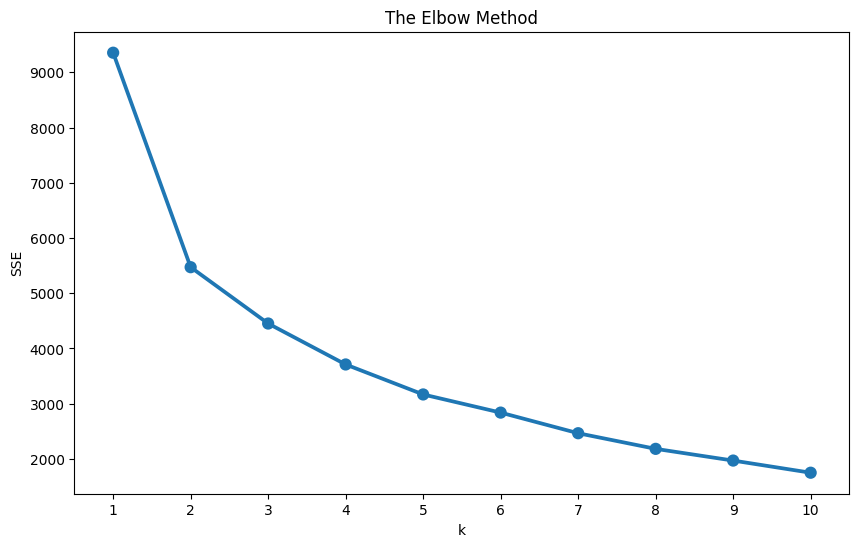

In [22]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

#Elbow Plot    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [23]:
#Final Model

model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)

customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         43.97      9.85        208.50  1153
1         44.10      1.98        -17.35   907
2        228.67      1.81         33.98  1058

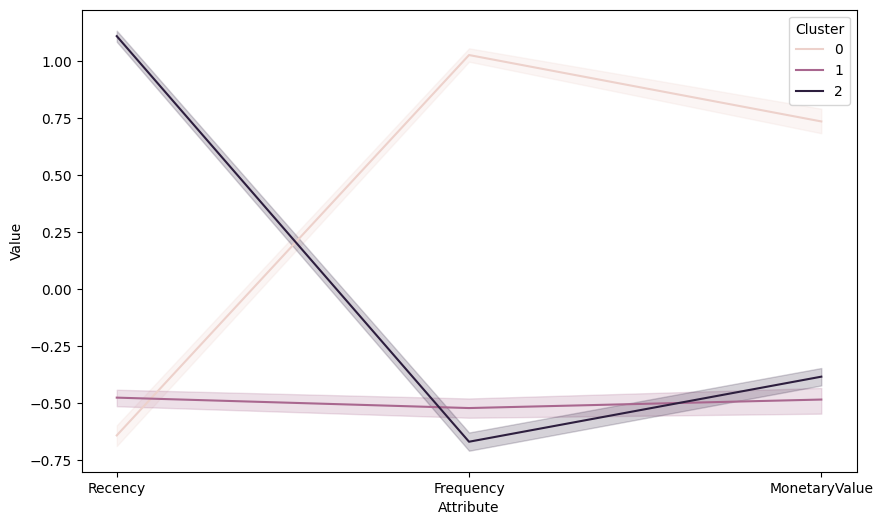

In [24]:
# Visualising the Cluster Chartecteristics

df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)
plt.show()